In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.patches as mpatches
import scanpy as sc
import anndata
from sklearn.neighbors import NearestNeighbors
from collections import Counter
import matplotlib
import scipy.stats as stats


In [2]:
all_cells_umap = pd.read_csv("UMAP_Integrated.csv")

/tmp/ipykernel_24544/799857196.py:1: DtypeWarning: Columns (11,12,21,22,25,26,27,28,29,30,31,32,33,34,35,39,44) have mixed types. Specify dtype option on import or set low_memory=False.
  all_cells_umap = pd.read_csv("UMAP_Integrated.csv")


In [3]:
ctrl_cell_only_umap = all_cells_umap[~all_cells_umap["cell_type_fine"].isna()]

/home/ubuntu/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


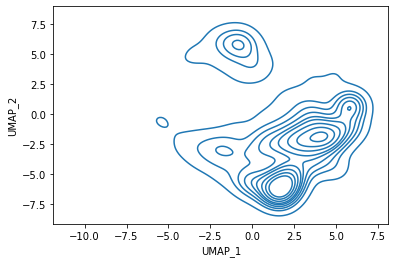

In [4]:
sns.kdeplot(ctrl_cell_only_umap["UMAP_1"], ctrl_cell_only_umap["UMAP_2"])
plt.show()

<AxesSubplot:xlabel='UMAP_1', ylabel='UMAP_2'>

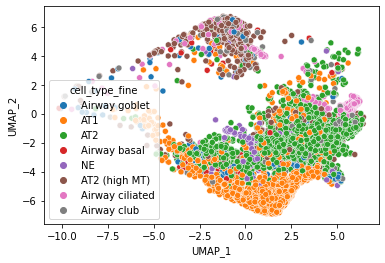

In [5]:
sns.scatterplot(data=ctrl_cell_only_umap, x="UMAP_1", y="UMAP_2", hue="cell_type_fine")


/home/ubuntu/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'lw'
  cset = contour_func(


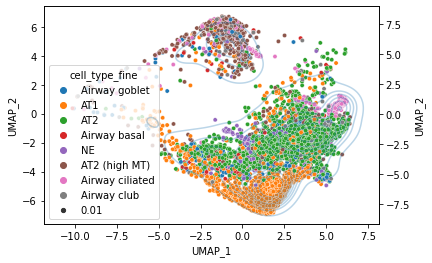

In [6]:
fig, ax = plt.subplots()
sns.scatterplot(data=all_cells_umap, x="UMAP_1", y="UMAP_2", hue="cell_type_fine", ax  = ax, size = 0.01)
ax2 = ax.twinx()
kdeplot = sns.kdeplot(data=ctrl_cell_only_umap, x="UMAP_1", y="UMAP_2", fill = False, ax = ax2, alpha=0.3, lw=20)


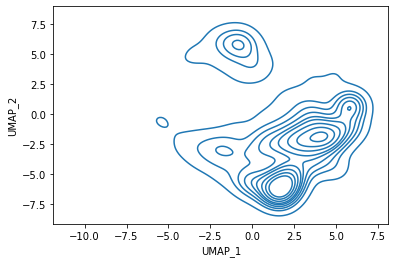

In [7]:
kde = sns.kdeplot(data=ctrl_cell_only_umap, x="UMAP_1", y="UMAP_2")
ctrl_contours = []
for i in kde.get_children():
    if i.__class__.__name__ == 'PathCollection':
        ctrl_contours.append(i.get_paths())

(-8.0, 8.0)

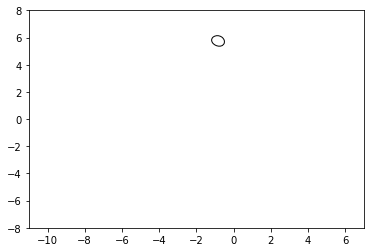

In [8]:
fig, ax = plt.subplots()
for x in ctrl_contours[3:4]:
    for y in x[1:2]:
        ax.add_patch(mpatches.PathPatch(
            y,
            fc ="none", transform = ax.transData))

plt.xlim([-11, 7])
plt.ylim([-8, 8])

In [9]:
##ASSIGNED PEAKS Assigned in above data

peaks = {
 "AT2_high_MT" : ctrl_contours[3][1],
 "Airway_Ciliated":ctrl_contours[5][2],
 "AT1": ctrl_contours[8][0],
 "AT2-Main": ctrl_contours[8][1], 
 "NA-Peak": ctrl_contours[0][1],
 "AT2-Second": ctrl_contours[2][1]
}

palette = {
 "AT2_high_MT_cluster" : "#ff0000",
 "Airway_Ciliated_cluster": "#ffd700",
 "AT1_cluster": "#c71585",
 "AT2-Main_cluster": "#7fffd4", 
 "NA-Peak_cluster": "#00ff00",
 "AT2-Second_cluster": "#808000",
 "Mixed Lineage": "#808080"
    
}

cols = []

points = list(zip(ctrl_cell_only_umap.UMAP_1, ctrl_cell_only_umap.UMAP_2))
points
for x in peaks:
    ctrl_cell_only_umap[x + "_cluster"] = peaks[x].contains_points(points)
    cols.append(x + "_cluster")
assigned_cluster_knn_training = []


for i,x in ctrl_cell_only_umap.iterrows():
    found = False
    for y in cols:
        if x[y] and not found:
            assigned_cluster_knn_training.append(y)
            found = True
    if not found:
        assigned_cluster_knn_training.append("None")

ctrl_cell_only_umap["assigned_cluster_knn_training"] = assigned_cluster_knn_training



/tmp/ipykernel_24544/1754739421.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ctrl_cell_only_umap[x + "_cluster"] = peaks[x].contains_points(points)
/tmp/ipykernel_24544/1754739421.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ctrl_cell_only_umap[x + "_cluster"] = peaks[x].contains_points(points)
/tmp/ipykernel_24544/1754739421.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

In [10]:
#Load PCA data

In [11]:
"""
rna_counts = pd.read_csv("integrated_cell_data_counts.csv")
rna_counts= rna_counts.set_index("Unnamed: 0").T
rna_counts = rna_counts[rna_counts.index.isin(all_cells_umap["Unnamed: 0"])]
adata = anndata.AnnData(X= rna_counts, obs = all_cells_umap.set_index("Unnamed: 0"))


sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata, n_components=10)
sc.tl.pca(adata, n_comps=10)
pca_counts = pd.DataFrame(adata.obsm["X_pca"], index = adata.obs.index)
pca_counts.to_pickle("pca_counts.pkl")

"""

pca_counts = pd.read_pickle("pca_counts.pkl")

In [12]:
#Nearest Neighbor Model
neigh = NearestNeighbors(n_neighbors=10)
neigh.fit(pca_counts)

#Training_data
train = ctrl_cell_only_umap[ctrl_cell_only_umap["assigned_cluster_knn_training"] != "None"]

train_x = pca_counts.loc[list(train["Unnamed: 0"])]


cluster_dictionary_pca = {}
cluster_dictionary_pca_listed = {}

In [13]:
for cluster in set(train["assigned_cluster_knn_training"]):
    
    
    rng = neigh.kneighbors(
        train_x.loc[list(train[train["assigned_cluster_knn_training"] == cluster]["Unnamed: 0"])])
    
    #Set of all cells assigned to given cluster
    all_indexes = set()
    all_indexes_list = []
    
    #Iterate through first round of identified neighbors, add to all_indexes
    for x in rng[1]:
        all_indexes = all_indexes | set(x)
        all_indexes_list.extend(list(set(x)))
    
    
    
    to_find_neighbors = set(all_indexes)
    previous_search= set()
    
    #Repeat iterations 5 times. Add cells to to_find_neighbors
    for iteration in range(5):
        print(len(to_find_neighbors))
        cells = pca_counts.reset_index().loc[to_find_neighbors].set_index("Unnamed: 0")
        rng = neigh.kneighbors(cells)
        previous_search = previous_search | to_find_neighbors
        to_find_neighbors = set()
        for x in rng[1]:
            to_find_neighbors = to_find_neighbors | set(x)
            all_indexes = all_indexes | set(x)
            all_indexes_list.extend(list(set(x)))
        
        #avoid re-computing data on previously searched neighbors 
        to_find_neighbors = to_find_neighbors - previous_search
        
        
        
    cells = pca_counts.reset_index().loc[all_indexes]
    t = all_cells_umap.set_index("Unnamed: 0").loc[set(all_cells_umap["Unnamed: 0"]) & set(cells["Unnamed: 0"])]
    
    cluster_dictionary_pca[cluster] = set(all_cells_umap["Unnamed: 0"]) & set(cells["Unnamed: 0"])
    
    cluster_dictionary_pca_listed[cluster] = all_indexes_list

241


/tmp/ipykernel_24544/4233669497.py:24: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  cells = pca_counts.reset_index().loc[to_find_neighbors].set_index("Unnamed: 0")


612


/tmp/ipykernel_24544/4233669497.py:24: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  cells = pca_counts.reset_index().loc[to_find_neighbors].set_index("Unnamed: 0")


1372


/tmp/ipykernel_24544/4233669497.py:24: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  cells = pca_counts.reset_index().loc[to_find_neighbors].set_index("Unnamed: 0")


2488


/tmp/ipykernel_24544/4233669497.py:24: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  cells = pca_counts.reset_index().loc[to_find_neighbors].set_index("Unnamed: 0")


3681


/tmp/ipykernel_24544/4233669497.py:24: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  cells = pca_counts.reset_index().loc[to_find_neighbors].set_index("Unnamed: 0")
/tmp/ipykernel_24544/4233669497.py:38: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  cells = pca_counts.reset_index().loc[all_indexes]
/tmp/ipykernel_24544/4233669497.py:39: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  t = all_cells_umap.set_index("Unnamed: 0").loc[set(all_cells_umap["Unnamed: 0"]) & set(cells["Unnamed: 0"])]


1233


/tmp/ipykernel_24544/4233669497.py:24: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  cells = pca_counts.reset_index().loc[to_find_neighbors].set_index("Unnamed: 0")


1861


/tmp/ipykernel_24544/4233669497.py:24: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  cells = pca_counts.reset_index().loc[to_find_neighbors].set_index("Unnamed: 0")


2914


/tmp/ipykernel_24544/4233669497.py:24: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  cells = pca_counts.reset_index().loc[to_find_neighbors].set_index("Unnamed: 0")


3315


/tmp/ipykernel_24544/4233669497.py:24: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  cells = pca_counts.reset_index().loc[to_find_neighbors].set_index("Unnamed: 0")


3457


/tmp/ipykernel_24544/4233669497.py:24: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  cells = pca_counts.reset_index().loc[to_find_neighbors].set_index("Unnamed: 0")
/tmp/ipykernel_24544/4233669497.py:38: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  cells = pca_counts.reset_index().loc[all_indexes]
/tmp/ipykernel_24544/4233669497.py:39: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  t = all_cells_umap.set_index("Unnamed: 0").loc[set(all_cells_umap["Unnamed: 0"]) & set(cells["Unnamed: 0"])]


379


/tmp/ipykernel_24544/4233669497.py:24: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  cells = pca_counts.reset_index().loc[to_find_neighbors].set_index("Unnamed: 0")


594


/tmp/ipykernel_24544/4233669497.py:24: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  cells = pca_counts.reset_index().loc[to_find_neighbors].set_index("Unnamed: 0")


730


/tmp/ipykernel_24544/4233669497.py:24: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  cells = pca_counts.reset_index().loc[to_find_neighbors].set_index("Unnamed: 0")


849


/tmp/ipykernel_24544/4233669497.py:24: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  cells = pca_counts.reset_index().loc[to_find_neighbors].set_index("Unnamed: 0")


1137


/tmp/ipykernel_24544/4233669497.py:24: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  cells = pca_counts.reset_index().loc[to_find_neighbors].set_index("Unnamed: 0")
/tmp/ipykernel_24544/4233669497.py:38: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  cells = pca_counts.reset_index().loc[all_indexes]
/tmp/ipykernel_24544/4233669497.py:39: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  t = all_cells_umap.set_index("Unnamed: 0").loc[set(all_cells_umap["Unnamed: 0"]) & set(cells["Unnamed: 0"])]


1871


/tmp/ipykernel_24544/4233669497.py:24: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  cells = pca_counts.reset_index().loc[to_find_neighbors].set_index("Unnamed: 0")


1690


/tmp/ipykernel_24544/4233669497.py:24: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  cells = pca_counts.reset_index().loc[to_find_neighbors].set_index("Unnamed: 0")


3578


/tmp/ipykernel_24544/4233669497.py:24: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  cells = pca_counts.reset_index().loc[to_find_neighbors].set_index("Unnamed: 0")


4679


/tmp/ipykernel_24544/4233669497.py:24: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  cells = pca_counts.reset_index().loc[to_find_neighbors].set_index("Unnamed: 0")


4863


/tmp/ipykernel_24544/4233669497.py:24: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  cells = pca_counts.reset_index().loc[to_find_neighbors].set_index("Unnamed: 0")
/tmp/ipykernel_24544/4233669497.py:38: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  cells = pca_counts.reset_index().loc[all_indexes]
/tmp/ipykernel_24544/4233669497.py:39: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  t = all_cells_umap.set_index("Unnamed: 0").loc[set(all_cells_umap["Unnamed: 0"]) & set(cells["Unnamed: 0"])]


89


/tmp/ipykernel_24544/4233669497.py:24: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  cells = pca_counts.reset_index().loc[to_find_neighbors].set_index("Unnamed: 0")


253


/tmp/ipykernel_24544/4233669497.py:24: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  cells = pca_counts.reset_index().loc[to_find_neighbors].set_index("Unnamed: 0")


623


/tmp/ipykernel_24544/4233669497.py:24: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  cells = pca_counts.reset_index().loc[to_find_neighbors].set_index("Unnamed: 0")


1156


/tmp/ipykernel_24544/4233669497.py:24: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  cells = pca_counts.reset_index().loc[to_find_neighbors].set_index("Unnamed: 0")


2217


/tmp/ipykernel_24544/4233669497.py:24: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  cells = pca_counts.reset_index().loc[to_find_neighbors].set_index("Unnamed: 0")
/tmp/ipykernel_24544/4233669497.py:38: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  cells = pca_counts.reset_index().loc[all_indexes]
/tmp/ipykernel_24544/4233669497.py:39: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  t = all_cells_umap.set_index("Unnamed: 0").loc[set(all_cells_umap["Unnamed: 0"]) & set(cells["Unnamed: 0"])]


199


/tmp/ipykernel_24544/4233669497.py:24: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  cells = pca_counts.reset_index().loc[to_find_neighbors].set_index("Unnamed: 0")


160


/tmp/ipykernel_24544/4233669497.py:24: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  cells = pca_counts.reset_index().loc[to_find_neighbors].set_index("Unnamed: 0")


535


/tmp/ipykernel_24544/4233669497.py:24: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  cells = pca_counts.reset_index().loc[to_find_neighbors].set_index("Unnamed: 0")


1423


/tmp/ipykernel_24544/4233669497.py:24: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  cells = pca_counts.reset_index().loc[to_find_neighbors].set_index("Unnamed: 0")


2372


/tmp/ipykernel_24544/4233669497.py:24: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  cells = pca_counts.reset_index().loc[to_find_neighbors].set_index("Unnamed: 0")
/tmp/ipykernel_24544/4233669497.py:38: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  cells = pca_counts.reset_index().loc[all_indexes]
/tmp/ipykernel_24544/4233669497.py:39: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  t = all_cells_umap.set_index("Unnamed: 0").loc[set(all_cells_umap["Unnamed: 0"]) & set(cells["Unnamed: 0"])]


In [14]:
#Adjust for cells that may have been assigned multiple times (and sometimes to multiple clusters)

cluster_counters = {}
for x in cluster_dictionary_pca_listed:
    cluster_counters[x] = Counter(cluster_dictionary_pca_listed[x])
    
count_dict = pca_counts.reset_index()["Unnamed: 0"].to_dict()
count_dict = dict([(value, key) for key, value in count_dict.items()])


In [15]:
all_cells = set()
for x in cluster_dictionary_pca:
    all_cells = all_cells | cluster_dictionary_pca[x]
cell_assigned_cluster = {}
for x in all_cells:
    max_c = 0
    type_val = ""
    for y in cluster_dictionary_pca:
        if x in cluster_dictionary_pca[y]:
            count = cluster_counters[y][count_dict[x]]
            
            if count > max_c:
                max_c = count
                type_val = y
    cell_assigned_cluster[x] = type_val

In [16]:
def assign_cell(cell, cell_type):
    if cell in cell_assigned_cluster:
        return cell_assigned_cluster[cell]
    
    
    return "Mixed Lineage"

all_cells_umap["Nearest_clustering_PCA"] = all_cells_umap.apply(lambda x: assign_cell(x["Unnamed: 0"], x["cell_type_fine"]), axis = 1)

In [17]:
tumor_cells_only = all_cells_umap[~all_cells_umap["orig.ident"].isin(['C51ctr',
 'C52ctr',
 'C53ctr',
 'C54ctr',
 'C55ctr',
 'C57ctr'])]


#Percentage of Mixed-Lineage Cells
len(tumor_cells_only[tumor_cells_only["Nearest_clustering_PCA"]== "Mixed Lineage"])/len(tumor_cells_only)

0.8295239149383621

/home/ubuntu/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


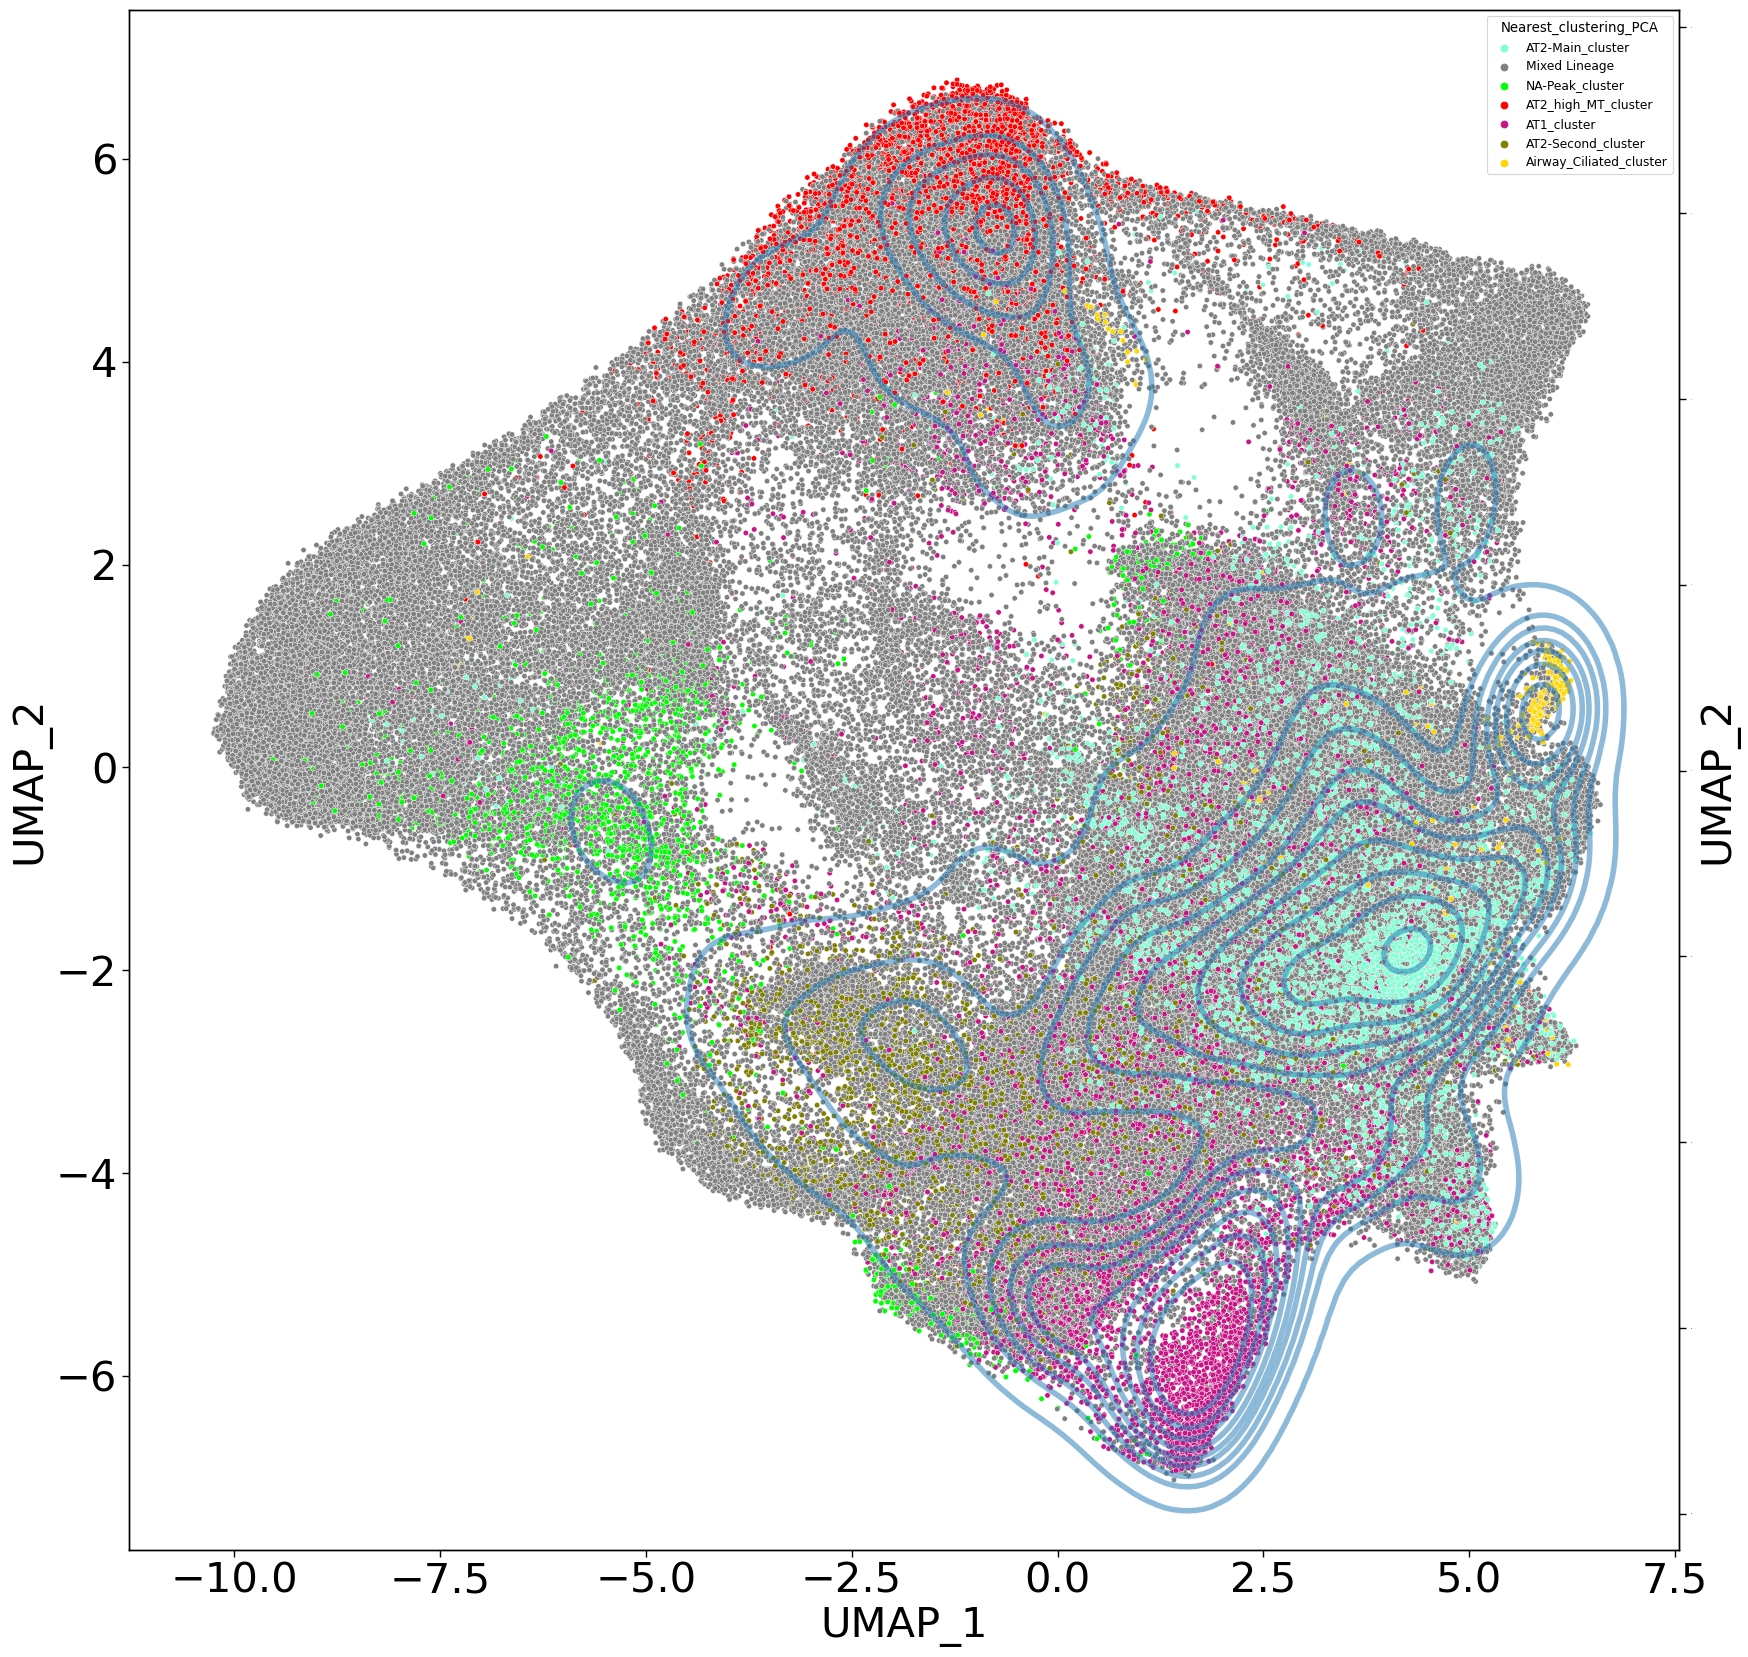

In [18]:
matplotlib.rc_file_defaults()
plt.rcParams['figure.figsize']=(20,20)


palette = {
 "AT2_high_MT_cluster" : "#ff0000",
 "Airway_Ciliated_cluster": "#ffd700",
 "AT1_cluster": "#c71585",
 "AT2-Main_cluster": "#7fffd4", 
 "NA-Peak_cluster": "#00ff00",
 "AT2-Second_cluster": "#808000",
 "Mixed Lineage": "#808080"
    
}
sns.set_context("paper", rc={"font.size":20,"axes.titlesize":30,"axes.labelsize":30})   
fig, ax = plt.subplots()

t = sns.scatterplot(data=all_cells_umap, x="UMAP_1", y="UMAP_2", hue="Nearest_clustering_PCA", ax=ax, palette=palette, s=15)
t.tick_params(labelsize=30)


ax2 = ax.twinx()

t2 = sns.kdeplot(data=ctrl_cell_only_umap, x="UMAP_1", y="UMAP_2", fill = False, ax = ax2, linewidths=4,  
            alpha=0.5, bw=0.15)

t2.tick_params(labelsize=0)


<AxesSubplot:xlabel='UMAP_1', ylabel='UMAP_2'>

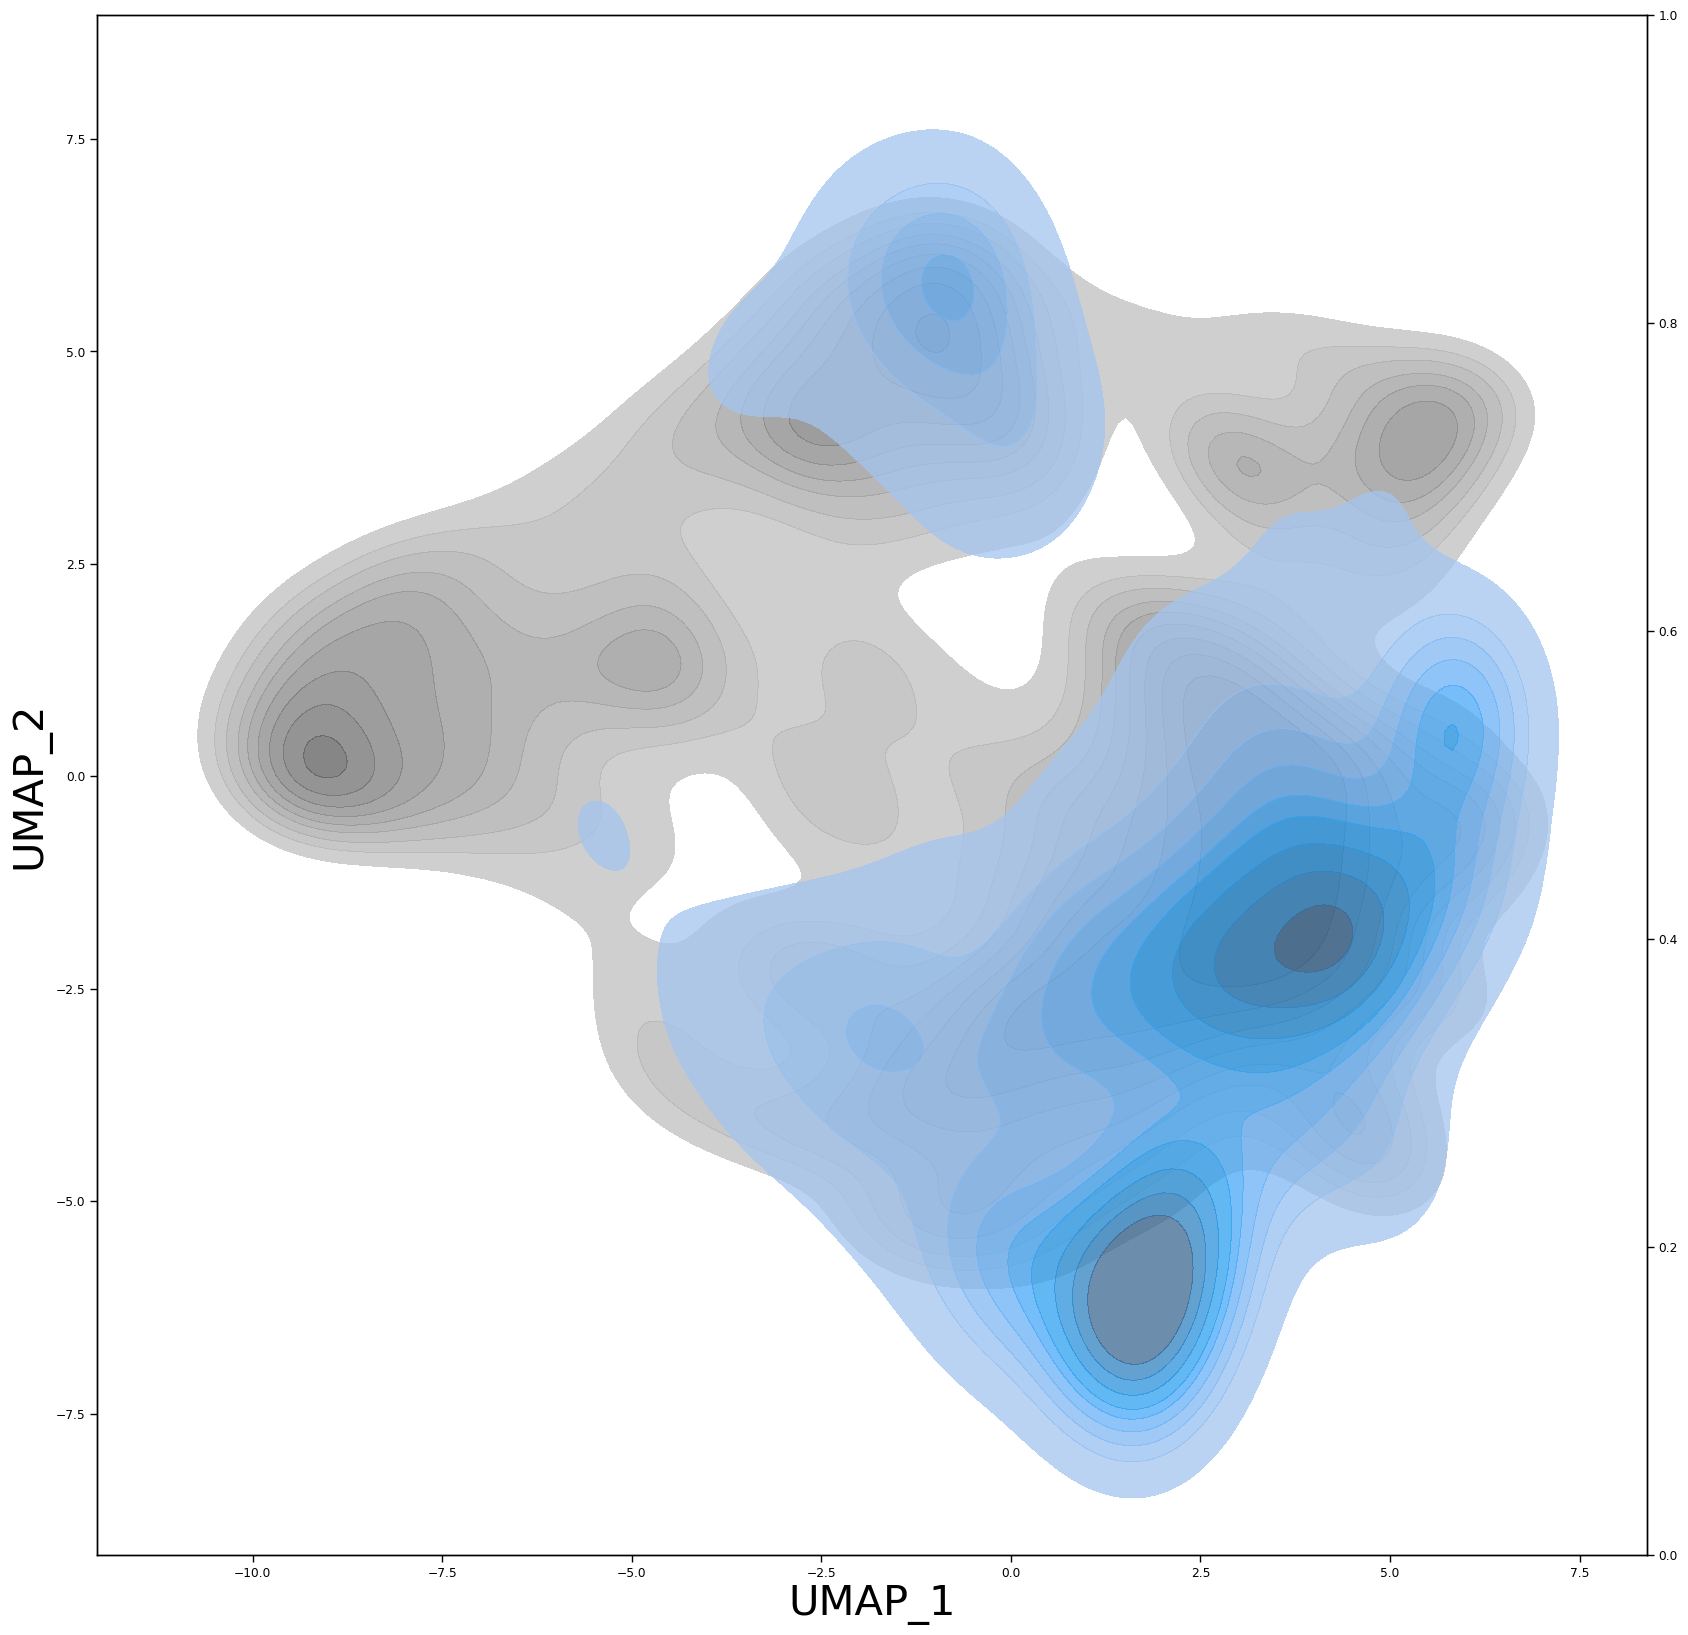

In [19]:
fig, ax = plt.subplots()

mixed_lineage_umap = all_cells_umap[all_cells_umap["Nearest_clustering_PCA"]== "Mixed Lineage"]
sns.kdeplot(data=mixed_lineage_umap, x="UMAP_1", y="UMAP_2", fill = True, color="#808080", ax = ax, alpha=.75)


ax2 = ax.twinx()


sns.kdeplot(data=ctrl_cell_only_umap, x="UMAP_1", y="UMAP_2", fill = True, ax = ax, alpha=.75)


In [20]:
#P_value Computation

bootstrap_size = 500
num_bootstraps = 100
comparisions = {'Primary_vs_BM', 'STK11mut_vs_NonSTK11mut', 'Primary_BM_STK_NonSTK'}
bootstrap_dfs = {}
tumor_only = tumor_cells_only


for y in comparisions:
    bootstrap_dfs[y] = []
for i in range(num_bootstraps):
    df = tumor_only.sample(n=bootstrap_size, random_state=i)
    for y in comparisions:
        samp = df.groupby([y,'Nearest_clustering_PCA']).size().unstack(fill_value=0)
        samp = samp.div(samp.sum(axis=1), axis=0)
        bootstrap_dfs[y].append(samp)

In [21]:
    with pd.ExcelWriter('TumorCellAssignCountMatrix.xlsx') as writer: 
        
        arr = [tumor_only.groupby(['Primary_BM_STK_NonSTK','Nearest_clustering_PCA']).size().unstack(fill_value=0),
                tumor_only.groupby(['Primary_vs_BM','Nearest_clustering_PCA']).size().unstack(fill_value=0),
                tumor_only.groupby(['STK11mut_vs_NonSTK11mut','Nearest_clustering_PCA']).size().unstack(fill_value=0),
                tumor_only.groupby(['STK11mut_vs_NonSTK11mut','Nearest_clustering_PCA']).size().unstack(fill_value=0)

            ]
        merged_dfs = pd.concat(arr)
        merged_dfs.to_excel(writer, sheet_name='markers_count')
        res = merged_dfs.div(merged_dfs.sum(axis=1), axis=0)
        res.to_excel(writer, sheet_name='markers_percent')
        for comp in {'Primary_vs_BM', 'STK11mut_vs_NonSTK11mut'}:
            
            comparision = comp

            all_columns = set()
            for y in bootstrap_dfs[comparision]:
                all_columns = all_columns | set(y.columns)

            columns = all_columns
            type_dict = {}
            for y in columns:
                type_dict[y] = []
                for obj in range(len(bootstrap_dfs[comparision][0])):
                    type_dict[y].append([])
            p_values = {}   
            for iteration in bootstrap_dfs[comparision]:

                for y in columns:
                    if y not in iteration.columns:
                        for z in range(len(bootstrap_dfs[comparision][0])):
                            type_dict[y][z].append(0)
                    else:
                        for z in range(len(bootstrap_dfs[comparision][0])):
                            type_dict[y][z].append(list(iteration[y])[z])
                    vals1 = stats.ttest_ind(a=type_dict[y][0], b=type_dict[y][1], equal_var=True, alternative='less').pvalue
                    vals2 = stats.ttest_ind(a=type_dict[y][0], b=type_dict[y][1], equal_var=True, alternative='greater').pvalue

                    p_values[y] =[ vals1 * len(columns) , vals2 * len(columns)]
            pvaldf = pd.DataFrame(p_values)[merged_dfs.columns]
            pvaldf.index = bootstrap_dfs[comparision][0].index
            pvaldf.to_excel(writer, sheet_name=comp+'_pvalue')
            
        for temp_Val in range(1):
            
            comparision = 'Primary_BM_STK_NonSTK'
            dataframe = x

            all_columns = set()
            for y in bootstrap_dfs[comparision]:
                all_columns = all_columns | set(y.columns)

            columns = all_columns
            type_dict = {}
            for y in columns:
                type_dict[y] = []
                for obj in range(len(bootstrap_dfs[comparision][0])):
                    type_dict[y].append([])
            p_values1 = {} 
            p_values2 = {}
            p_values3 = {}
            p_values4 = {}
            for iteration in bootstrap_dfs[comparision]:

                for y in columns:
                    if y not in iteration.columns:
                        for z in range(len(bootstrap_dfs[comparision][0])):
                            type_dict[y][z].append(0)
                    else:
                        for z in range(len(bootstrap_dfs[comparision][0])):
                            type_dict[y][z].append(list(iteration[y])[z])
                    
                    vals1 = stats.ttest_ind(a=type_dict[y][0], b=type_dict[y][1], equal_var=True, alternative='less').pvalue
                    vals2 = stats.ttest_ind(a=type_dict[y][0], b=type_dict[y][1], equal_var=True, alternative='greater').pvalue
                    p_values1[y] =[ vals1 * len(columns) , vals2 * len(columns)]
                    
                    vals1 = stats.ttest_ind(a=type_dict[y][0], b=type_dict[y][2], equal_var=True, alternative='less').pvalue
                    vals2 = stats.ttest_ind(a=type_dict[y][0], b=type_dict[y][2], equal_var=True, alternative='greater').pvalue
                    p_values2[y] =[ vals1 * len(columns) , vals2 * len(columns)]
                    
                    vals1 = stats.ttest_ind(a=type_dict[y][1], b=type_dict[y][3], equal_var=True, alternative='less').pvalue
                    vals2 = stats.ttest_ind(a=type_dict[y][1], b=type_dict[y][3], equal_var=True, alternative='greater').pvalue
                    p_values3[y] =[ vals1 * len(columns) , vals2 * len(columns)]

                    vals1 = stats.ttest_ind(a=type_dict[y][2], b=type_dict[y][3], equal_var=True, alternative='less').pvalue
                    vals2 = stats.ttest_ind(a=type_dict[y][2], b=type_dict[y][3], equal_var=True, alternative='greater').pvalue
                    p_values4[y] =[ vals1 * len(columns) , vals2 * len(columns)]


            pvaldf = pd.DataFrame(p_values1)[merged_dfs.columns]
            pvaldf.index = ['Non-STK11-mut (BRAIN_METS)', 'Non-STK11-mut (PRIMARY)'
                           ]
            pvaldf.to_excel(writer, sheet_name="nonSTK_PRI_v_BRAIN_pvalue")

            pvaldf = pd.DataFrame(p_values2)[merged_dfs.columns]
            pvaldf.index = ['Non-STK11-mut (BRAIN_METS)', 
                           'STK11-mut (BRAIN_METS)']
            pvaldf.to_excel(writer, sheet_name="BRAIN_nonSTK_v_STK_pvalue")

            pvaldf = pd.DataFrame(p_values3)[merged_dfs.columns]
            pvaldf.index = [ 'Non-STK11-mut (PRIMARY)',
                           'STK11-mut (PRIMARY)']
            pvaldf.to_excel(writer, sheet_name="PRI_nonSTK_v_STK_pvalue")
            
            pvaldf = pd.DataFrame(p_values4)[merged_dfs.columns]
            pvaldf.index = ['STK11-mut (BRAIN_METS)', 'STK11-mut (PRIMARY)']
            pvaldf.to_excel(writer, sheet_name="STK_PRI_v_BRAIN_pvalue")      

/home/ubuntu/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [22]:
cluster_21_cells = pd.read_csv("Cluster_21.csv")
cluster_21_cells["Unnamed: 0"] = cluster_21_cells.apply(lambda x: "Tumor_" + x["Unnamed: 0"], axis = 1)
all_cells_umap["Cluster21"] = all_cells_umap['Unnamed: 0'].isin(cluster_21_cells["Unnamed: 0"])

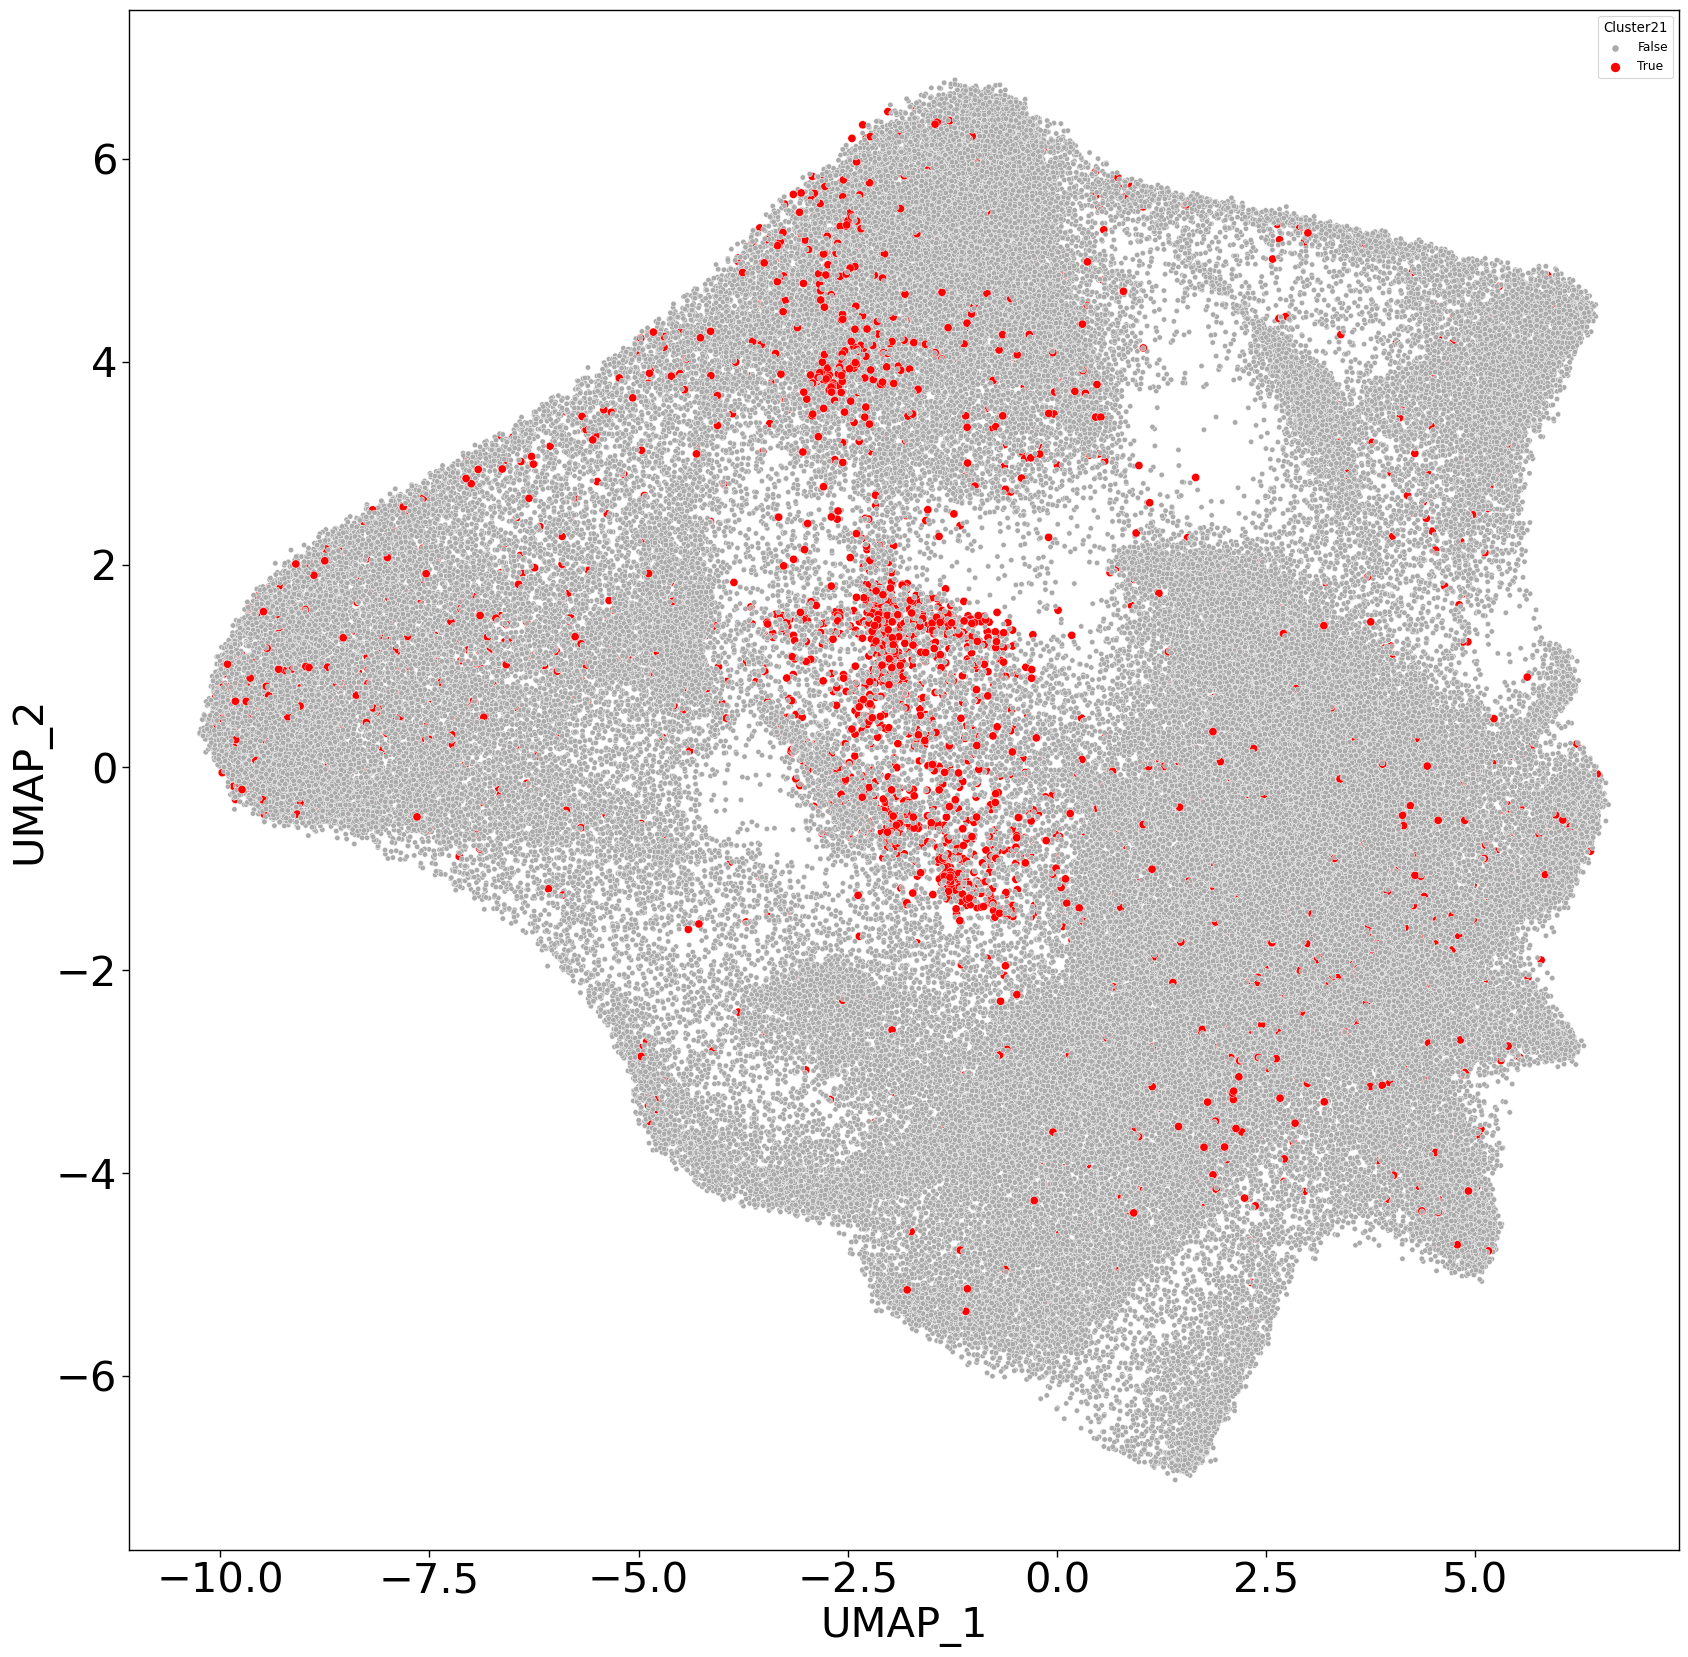

In [23]:
pallete = {
    True: "r",
    False: "#AAAAAA"
}

pallete_s = {
    True: 35,
    False: 15
}


import matplotlib
matplotlib.rc_file_defaults()
plt.rcParams['figure.figsize']=(20,20)


sns.set_context("paper", rc={"font.size":20,"axes.titlesize":30,"axes.labelsize":30})   


t = sns.scatterplot(data=all_cells_umap, x="UMAP_1", y="UMAP_2", hue="Cluster21",size = "Cluster21",
                sizes=pallete_s, palette=pallete)
sns.set_context("paper", rc={"font.size":20,"axes.titlesize":30,"axes.labelsize":30})   

t.tick_params(labelsize=30)